In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import numpy as np
import cv2
import glob
import time
#from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

#### 1. Read image file names for training(Skip this , execute 2 and then jump to 8 if training already done)

In [13]:
cars=[]
non_cars=[]
images = glob.glob('../Data-P5/non-vehicles/Extras/*.png')
non_cars.extend(images)
images = glob.glob('../Data-P5/non-vehicles/GTI/*.png')
non_cars.extend(images)
print('Total non car images:')
print(len(non_cars))

images = glob.glob('../Data-P5/vehicles/GTI_Far/*.png')
cars.extend(images)
images = glob.glob('../Data-P5/vehicles/GTI_Left/*.png')
cars.extend(images)
images = glob.glob('../Data-P5/vehicles/GTI_MiddleClose/*.png')
cars.extend(images)
images = glob.glob('../Data-P5/vehicles/GTI_Right/*.png')
cars.extend(images)
images = glob.glob('../Data-P5/vehicles/KITTI_extracted/*.png')
cars.extend(images)

print('Total  car images:')
print(len(cars))

Total non car images:
8968
Total  car images:
8792


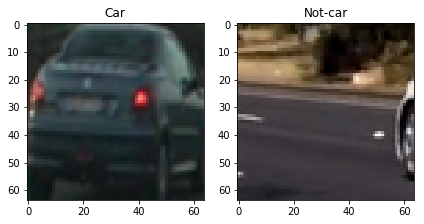

In [14]:
#Example of a car and non car image
car_image_ex = mpimg.imread(cars[1000])
non_car_image_ex = mpimg.imread(non_cars[1500])

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image_ex)
plt.title('Car')
plt.subplot(122)
plt.imshow(non_car_image_ex)
plt.title('Not-car')
fig.tight_layout()
fig.savefig('./output_images/car_not_car.png')

#### 2. Define get_hog_features, bin_spatial, color hist etc

In [15]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### 2.a Example of hog feature(skip if test not required)

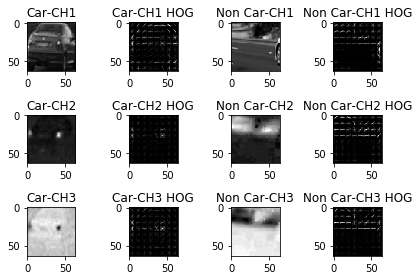

In [228]:
car_ex_ycrcb = cv2.cvtColor(car_image_ex, cv2.COLOR_RGB2YCrCb)
non_car_ex_ycrcb = cv2.cvtColor(non_car_image_ex, cv2.COLOR_RGB2YCrCb)

ch1=car_ex_ycrcb[:,:,0]
ch2=car_ex_ycrcb[:,:,1]
ch3=car_ex_ycrcb[:,:,2]
hog_feat1, hog_img1 = get_hog_features(car_ex_ycrcb[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feat2, hog_img2 = get_hog_features(car_ex_ycrcb[:,:,1], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feat3, hog_img3 = get_hog_features(car_ex_ycrcb[:,:,2], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)


n_ch1=non_car_ex_ycrcb[:,:,0]
n_ch2=non_car_ex_ycrcb[:,:,1]
n_ch3=non_car_ex_ycrcb[:,:,2]
hog_feat1, n_hog_img1 = get_hog_features(n_ch1, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feat2, n_hog_img2 = get_hog_features(n_ch2, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feat3, n_hog_img3 = get_hog_features(n_ch3, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

fig = plt.figure()
plt.subplot(341)
plt.imshow(ch1,cmap='gray')
plt.title('Car-CH1')
plt.subplot(342)
plt.imshow(hog_img1,cmap='gray')
plt.title('Car-CH1 HOG')
plt.subplot(345)
plt.imshow(ch2,cmap='gray')
plt.title('Car-CH2')
plt.subplot(346)
plt.imshow(hog_img2,cmap='gray')
plt.title('Car-CH2 HOG')
plt.subplot(349)
plt.imshow(ch3,cmap='gray')
plt.title('Car-CH3')
plt.subplot(3,4,10)
plt.imshow(hog_img3,cmap='gray')
plt.title('Car-CH3 HOG')

plt.subplot(343)
plt.imshow(n_ch1,cmap='gray')
plt.title('Non Car-CH1')
plt.subplot(344)
plt.imshow(n_hog_img1,cmap='gray')
plt.title('Non Car-CH1 HOG')
plt.subplot(347)
plt.imshow(n_ch2,cmap='gray')
plt.title('Non Car-CH2')
plt.subplot(348)
plt.imshow(n_hog_img2,cmap='gray')
plt.title('Non Car-CH2 HOG')
plt.subplot(3,4,11)
plt.imshow(n_ch3,cmap='gray')
plt.title('Non Car-CH3')
plt.subplot(3,4,12)
plt.imshow(n_hog_img3,cmap='gray')
plt.title('Non Car-CH3 HOG')
fig.tight_layout()
fig.savefig('./output_images/HOG_example.png')

#### 3. Extract features from a set of standalone images

In [16]:
#imgs: List of image file names
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #mpimg reads png images in a scale of 0 to 1
        #Here the image shape is 64 x 64 x3
        
        #an Image, that is scaled from 0 to 1, when applied to cv2.cvtColor(),
        #will be translated to a scale from 0 to 255.
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        #print(feature_image)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    #print(np.shape(features))
    return features

#### 4. Creating feature vectors for both car and non-car images for training, each training image is 64 x 64 x 3

In [17]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 9 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [None, None] # Min and max in y to search in slide_window()

#### Next cell is only for testing a single image; only for testing

In [17]:
'''
cars1=cars[0:1]
car_features1 = extract_features(cars1, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
'''

'\ncars1=cars[0:1]\ncar_features1 = extract_features(cars1, color_space=color_space, \n                        spatial_size=spatial_size, hist_bins=hist_bins, \n                        orient=orient, pix_per_cell=pix_per_cell, \n                        cell_per_block=cell_per_block, \n                        hog_channel=hog_channel, spatial_feat=spatial_feat, \n                        hist_feat=hist_feat, hog_feat=hog_feat)\n'

#### 6. Extract features for cars and non cars for training

In [18]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("Done")

Done


In [19]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [20]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 9 pixels per cell and 2 cells per block
Feature vector length: 2112


In [21]:
print(np.shape(X_train))
print(np.shape(X_test))

(14208, 2112)
(3552, 2112)


#### 7. Training a SVC

In [23]:
# Use a linear SVC 
#svc = LinearSVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
# Check the training time for the SVC
t=time.time()
#svc.fit(X_train, y_train)
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
#print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

svc_pickle = {}
#svc_pickle["svc"] = svc
svc_pickle["svc"] = clf
svc_pickle["scalar"] = X_scaler
svc_pickle["color_space"] = color_space
svc_pickle["orient"] = orient
svc_pickle["pix_per_cell"] = pix_per_cell
svc_pickle["cell_per_block"] = cell_per_block
svc_pickle["hog_channel"] = hog_channel
svc_pickle["spatial_size"] = spatial_size
svc_pickle["hist_bins"] = hist_bins
svc_pickle["spatial_feat"] = spatial_feat
svc_pickle["hist_feat"] = hist_feat
svc_pickle["hog_feat"] = hog_feat
pickle.dump(svc_pickle, open('svc_pickle.p',"wb"))
print("SVC saved in pickle")

831.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
SVC saved in pickle


#### 8. Find cars and draw box in an image; Start here if returning(execute 2 above)

In [24]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img,ystart,ystop,scale,svc,X_scaler,color_space,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,spatial_feat,hist_feat,hog_feat):
    
    #draw_img = np.copy(img)
    bboxes = []
    
    #To make it similar to the training data set images which were in scale of 0 to 1
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ##Color space conversion #############################
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
    #######################################################
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    #draw_img = np.copy(ctrans_tosearch)    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    #print(nxsteps)
    #print(nysteps)
    
    # Compute individual channel HOG features for the entire image
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=False
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            if hog_feat == True:
            # Extract HOG for this patch
                if hog_channel == 'ALL':
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    if hog_channel==0:
                        hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    elif hog_channel==1:
                        hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    elif hog_channel==2:
                        hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))#resize is kind of 
            #redundant, because, ctrans_tosearch[ytop:ytop+window, xleft:xleft+window] is already 64 x 64
            
            #This next step is required if we want to draw the sliding windows over the image
            #cv2.rectangle(draw_img,(int(xleft*scale),400+int(ytop*scale)),(int((xleft+window)*scale),400+int((ytop+window)*scale)),(0,255,0),3)
            
            # Get color features
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
                

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    #print('Feature vector length:', len(test_features[0]))
    #print("This should be same as the training feature vector length")
    return bboxes
    #return bboxes, draw_img

In [25]:
#Define different scale factors at differnet portions of the image
ystart1 = 400
ystop1 = 664
scale1 = 3

ystart2 = 400
ystop2 = 600
scale2 = 2.7

ystart3 = 400
ystop3 = 550
scale3 = 2

ystart4 = 400
ystop4 = 500
scale4 = 1.5

ystart5 = 400
ystop5 = 460
scale5 = 0.9

In [31]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scalar"]
color_space = dist_pickle["color_space"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

In [27]:
#Print configuration loaded from the pickle file
print(color_space)
print(hog_channel)
print(spatial_size)
print(hist_bins)
print(spatial_feat)
print(hist_feat)
print(hog_feat)

YCrCb
0
(16, 16)
16
True
True
True


#### 9. Testing on a single image

#### This step is to draw the sliding windows and this needs a special version of find_cars that returns an image, skip if not required

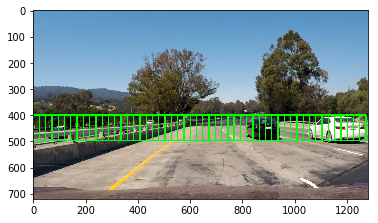

In [112]:
test_img = mpimg.imread('./test_images/test1.jpg')
bboxes3,draw_img3=find_cars(test_img,400, 500, 1.5, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat)
#bboxes3,draw_img3=find_cars(test_img,400, 460, 0.9, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat)
plt.imshow(draw_img3)
mpimg.imsave('./output_images/sliding_windows.png',draw_img3)

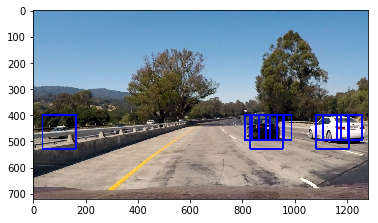

In [7]:
#Tesring on a single image
test_img = mpimg.imread('./test_images/test1.jpg')
draw_img=np.copy(test_img)
bounding_boxes=[]
#mpimg reads jpg images in a scale of 0 to 255
bounding_boxes.extend(find_cars(test_img,ystart4, ystop4, scale4, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
#print(bounding_boxes)
bounding_boxes.extend(find_cars(test_img, ystart3, ystop3, scale3, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
#print(bounding_boxes)
#print(np.shape(bboxes))

for box in bounding_boxes:
    #print(box)
    cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6)
                
plt.imshow(draw_img)
#plt.imshow(np.copy(test_img))
mpimg.imsave('./output_images/sliding_window.png',draw_img)

#### 10. Heatmap to discard duplicates and false positives; this step is required for heatmap on the video

In [32]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    #plt.imshow(heatmap,cmap='gray')
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### 11. Apply heatmap and mark true cars; for testing; skip if testing not required

In [33]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bounding_boxes)
#plt.imshow(heat,cmap='gray') 
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)
#plt.imshow(heatmap,cmap='gray')
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
#plt.imshow(heatmap,cmap='gray')
# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')



draw_img1 = draw_labeled_bboxes(np.copy(test_img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img1)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

NameError: name 'test_img' is not defined

#### 12. Video

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [35]:
class MyVideoProcessor(object):
    # constructor function
    def __init__(self):
        #self.last_frame_heat = []
        self.heatmaps = deque(maxlen = 5)
        return
    def pipeline(self, frame):
        bounding_boxes=[]
        #Positive windows are being detected at each frame of video
        bounding_boxes.extend(find_cars(frame, ystart5, ystop5, scale5, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
        bounding_boxes.extend(find_cars(frame, ystart4, ystop4, scale4, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
        bounding_boxes.extend(find_cars(frame, ystart3, ystop3, scale3, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
        bounding_boxes.extend(find_cars(frame, ystart2, ystop2, scale2, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
        
        heat = np.zeros_like(frame[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat,bounding_boxes)
        #heat = apply_threshold(heat,2)
        
        self.heatmaps.append(heat)
        combined = sum(self.heatmaps)
        
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(combined, 20)
        
        # Visualize the heatmap when displaying    
        #heatmap = np.clip(heat, 0, 255)
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        result_img = draw_labeled_bboxes(np.copy(frame), labels)
        
        return result_img

In [36]:
my_video_processor_object = MyVideoProcessor()
project_video_output = 'project_video_output.mp4'
#clip = VideoFileClip("project_video.mp4").subclip(0,12)
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(my_video_processor_object.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [37:19<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 34min 51s, sys: 1min 9s, total: 36min 1s
Wall time: 37min 21s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

#### Plot of heat map and Bounding boxes on multiple frames from the video

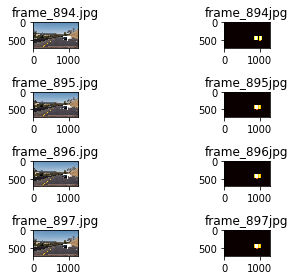

In [143]:
vid_frame1 = mpimg.imread('../project_vid_frames-P5/frame_894.jpg')
draw_img10=np.copy(vid_frame1)
bounding_boxes=[]
#mpimg reads jpg images in a scale of 0 to 255
bounding_boxes.extend(find_cars(vid_frame1,ystart4, ystop4, scale4, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
bounding_boxes.extend(find_cars(vid_frame1, ystart3, ystop3, scale3, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))

heat1 = np.zeros_like(vid_frame1[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat1 = add_heat(heat1,bounding_boxes)
#plt.imshow(heat,cmap='gray') 
# Apply threshold to help remove false positives
heat1 = apply_threshold(heat1,2)
#plt.imshow(heatmap,cmap='gray')
# Visualize the heatmap when displaying    
heatmap1 = np.clip(heat1, 0, 255)
#plt.imshow(heatmap,cmap='gray')
# Find final boxes from heatmap using label function
labels1 = label(heatmap1)
draw_img10 = draw_labeled_bboxes(np.copy(vid_frame1), labels1)

fig = plt.figure()
plt.subplot(421)
plt.imshow(draw_img10)
plt.title('frame_894.jpg')
plt.subplot(422)
plt.imshow(heatmap1, cmap='hot')
plt.title('frame_894jpg')

####

vid_frame2 = mpimg.imread('../project_vid_frames-P5/frame_895.jpg')
draw_img11=np.copy(vid_frame2)
bounding_boxes=[]
#mpimg reads jpg images in a scale of 0 to 255
bounding_boxes.extend(find_cars(vid_frame2,ystart4, ystop4, scale4, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
bounding_boxes.extend(find_cars(vid_frame2, ystart3, ystop3, scale3, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))

heat2 = np.zeros_like(vid_frame2[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat2 = add_heat(heat2,bounding_boxes)
#plt.imshow(heat,cmap='gray') 
# Apply threshold to help remove false positives
heat2 = apply_threshold(heat2,2)
#plt.imshow(heatmap,cmap='gray')
# Visualize the heatmap when displaying    
heatmap2 = np.clip(heat2, 0, 255)
#plt.imshow(heatmap,cmap='gray')
# Find final boxes from heatmap using label function
labels2 = label(heatmap2)
draw_img11 = draw_labeled_bboxes(np.copy(vid_frame2), labels2)

plt.subplot(423)
plt.imshow(draw_img11)
plt.title('frame_895.jpg')
plt.subplot(424)
plt.imshow(heatmap, cmap='hot')
plt.title('frame_895jpg')

###
vid_frame3 = mpimg.imread('../project_vid_frames-P5/frame_896.jpg')
draw_img12=np.copy(vid_frame3)
bounding_boxes=[]
#mpimg reads jpg images in a scale of 0 to 255
bounding_boxes.extend(find_cars(vid_frame3,ystart4, ystop4, scale4, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
bounding_boxes.extend(find_cars(vid_frame3, ystart3, ystop3, scale3, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))

heat3 = np.zeros_like(vid_frame3[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat3 = add_heat(heat3,bounding_boxes)
#plt.imshow(heat,cmap='gray') 
# Apply threshold to help remove false positives
heat3 = apply_threshold(heat3,2)
#plt.imshow(heatmap,cmap='gray')
# Visualize the heatmap when displaying    
heatmap3 = np.clip(heat3, 0, 255)
#plt.imshow(heatmap,cmap='gray')
# Find final boxes from heatmap using label function
labels3 = label(heatmap3)
draw_img12 = draw_labeled_bboxes(np.copy(vid_frame3), labels3)

plt.subplot(425)
plt.imshow(draw_img12)
plt.title('frame_896.jpg')
plt.subplot(426)
plt.imshow(heatmap, cmap='hot')
plt.title('frame_896jpg')

####

vid_frame4 = mpimg.imread('../project_vid_frames-P5/frame_897.jpg')
draw_img13=np.copy(vid_frame1)
bounding_boxes=[]
#mpimg reads jpg images in a scale of 0 to 255
bounding_boxes.extend(find_cars(vid_frame4,ystart4, ystop4, scale4, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))
bounding_boxes.extend(find_cars(vid_frame4, ystart3, ystop3, scale3, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat))

heat4 = np.zeros_like(vid_frame1[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat4 = add_heat(heat4,bounding_boxes)
#plt.imshow(heat,cmap='gray') 
# Apply threshold to help remove false positives
heat4 = apply_threshold(heat4,2)
#plt.imshow(heatmap,cmap='gray')
# Visualize the heatmap when displaying    
heatmap4 = np.clip(heat4, 0, 255)
#plt.imshow(heatmap,cmap='gray')
# Find final boxes from heatmap using label function
labels4 = label(heatmap4)
draw_img13 = draw_labeled_bboxes(np.copy(vid_frame4), labels4)

plt.subplot(427)
plt.imshow(draw_img10)
plt.title('frame_897.jpg')
plt.subplot(428)
plt.imshow(heatmap, cmap='hot')
plt.title('frame_897jpg')
fig.tight_layout()
fig.savefig('./output_images/bboxes_and_heat.png')

#### output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all four frames selected above

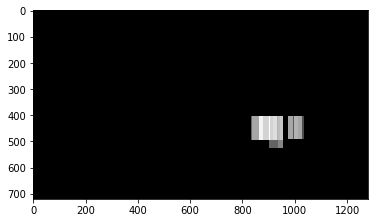

In [162]:
combined_heat1 = heat1 + heat2 + heat3 + heat4
heat_comb = apply_threshold(combined_heat1,5)
heatmap_comb = np.clip(heat_comb, 0, 255)
#plt.imshow(heatmap_comb, cmap='hot')
labels_comb = label(heatmap_comb)
result_img_comb = draw_labeled_bboxes(heatmap_comb, labels_comb)
plt.imshow(result_img_comb,cmap='gray')
mpimg.imsave('./output_images/labels_map.png',result_img_comb)

#### Bounding boxes are drawn onto the last frame in the series

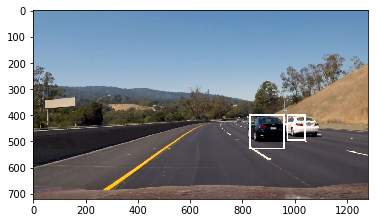

In [164]:
labels = label(heatmap)
result_img_last_frame = draw_labeled_bboxes(np.copy(vid_frame4), labels_comb)
plt.imshow(result_img_last_frame)
mpimg.imsave('./output_images/output_bboxes.png',result_img_last_frame)